### Import Packages

In [1]:
#Import Pacakges
import pandas as pd
from sbmtm import sbmtm
import graph_tool.all as gt
import pickle
import numpy as np
import pylab as plt
import seaborn as sns

### Import & Process Data

In [102]:
#filtered_data = pd.read_csv('/Users/ognyansimeonov/Desktop/MAC-MIGS/PhD/Code/Data/Transactions_Data_with_COICOP.csv')
filtered_data = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='Clean_Transfers')
mcc_dict = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='MCC_List', skiprows=10, usecols='A:B', names=['mcc_code', 'Description'])

### data cleaning
# select transactions with amount > 10
filtered_data = filtered_data[filtered_data['amount.value'] > 10]
# select customers with more than 10 transactions
filtered_data = filtered_data[filtered_data['customerId'].map(filtered_data['customerId'].value_counts()) > 10]
# map the mcc_dict to the filtered_data and drop the rows with NaN MCC values
filtered_data['MCC_List'] = filtered_data['externalParty.merchantCategoryCode'].map(mcc_dict.set_index('mcc_code')['Description'])
filtered_data = filtered_data.dropna(subset=['MCC_List'])
# fill the missing carbon emission values with the calculated carbon emission values based on the emission rate of the MCC
# calculate the emission rate of each transaction
filtered_data['emission_rate'] = filtered_data.apply(lambda x: x['transactionFootPrint.carbonEmissionInGrams']/x['amount.value'] if x['amount.value']!=0 else 0, axis=1)
# find the emission rate of each MCC
df_emission_rate = filtered_data.groupby('MCC_List')['emission_rate'].max().sort_values(ascending=True).reset_index().set_index('MCC_List').fillna(0)
# calculate the carbon emission of each transaction where missing
filtered_data['transactionFootPrint.carbonEmissionInGrams'] = filtered_data.apply(lambda x: x['amount.value']*df_emission_rate.loc[x['MCC_List']], axis=1)


df = filtered_data 

# Create a dictionary to store MCC lists for each customer
customer_mcc_dict = {}

# Iterate through the dataframe
for _, row in df.iterrows():
    customer_id = row['customerId']
    mcc = row['MCC_List']

    # Check if the customer_id is already in the dictionary
    if customer_id in customer_mcc_dict:
        customer_mcc_dict[customer_id].append(mcc)
    else:
        customer_mcc_dict[customer_id] = [mcc]

In [103]:
print(filtered_data.shape)
filtered_data.head()

(20324, 15)


,_id,accountId,customerId,IMD_Decile,createdAt,amount.currency,amount.exponent,amount.value,externalParty.merchantCategoryCode,externalParty.transactionCategory,MCC_List,transactionFootPrint.carbonEmissionInGrams,transactionType.code,transactionType.direction,emission_rate
0,6220c8e159378700114a8722,61c5e725941a0600135559cf,4ec3aa2c-1dcd-47a7-b20c-ce7083ddbab8,9,2022-03-03T13:55:45.434Z,GBP,2,5067,742,OTHER,Veterinary Services,10048.033278,REDEMPTION,DEBIT,1.944456
1,62c30db86daa10001266325e,6215fbb82c463a001166ad8f,a4c47159-e445-4b31-8ea9-6c5852bd7095,8,2022-07-04T15:56:40.950Z,GBP,2,4600,742,OTHER,Veterinary Services,9121.956400,REDEMPTION,DEBIT,1.983033
2,62e0fcf555577b00112d3176,625e873608ff4300110c62af,b5a28615-7994-458e-8903-8086ac77eb49,Not_Found,2022-07-27T08:53:09.433Z,GBP,2,5000,742,OTHER,Veterinary Services,9915.170000,REDEMPTION,DEBIT,1.983034
4,62c44ba62e447d00129fc612,61c453eebcc5e4001133f68a,fd654d64-f795-401d-a5fe-76cfa2cfa01a,10,2022-07-05T14:33:10.080Z,GBP,2,600,1520,SHOPPING,General Contractor/Residential Building,15224.930000,REDEMPTION,DEBIT,25.374883
5,62c5589f756f3f00119ec3b4,61c453eebcc5e4001133f68a,fd654d64-f795-401d-a5fe-76cfa2cfa01a,10,2022-07-06T09:40:47.483Z,GBP,2,600,1520,SHOPPING,General Contractor/Residential Building,15224.930000,REDEMPTION,DEBIT,25.374883


In [104]:
print('nunique customerId: '+str(filtered_data['customerId'].nunique()))
print('nunique mcc_code: '+str(filtered_data['externalParty.merchantCategoryCode'].nunique()))
print('nunique mcc_code: '+str(filtered_data['MCC_List'].nunique()))

nunique customerId: 369
nunique mcc_code: 199
nunique mcc_code: 199


In [105]:
filtered_data['externalParty.merchantCategoryCode'].value_counts()

externalParty.merchantCategoryCode
5411    4214
5812    2604
5814    1257
5499    1240
6011    1218
        ... 
5111       1
3029       1
9311       1
1711       1
3026       1
Name: count, Length: 199, dtype: int64

In [106]:
filtered_data.isnull().sum()

_id                                              0
accountId                                        0
customerId                                       0
IMD_Decile                                       0
createdAt                                        0
amount.currency                                  0
amount.exponent                                  0
amount.value                                     0
externalParty.merchantCategoryCode               0
externalParty.transactionCategory                0
MCC_List                                         0
transactionFootPrint.carbonEmissionInGrams       0
transactionType.code                             0
transactionType.direction                        0
emission_rate                                 1251
dtype: int64

In [107]:
# Create the CustomerID array
CustomerID = list(customer_mcc_dict.keys())

# Create the MCC array by zipping the two lists together
MCC = [customer_mcc_dict[customer_id] for customer_id in CustomerID]

# Check if all values in CustomerID are unique
are_all_unique = len(CustomerID) == len(set(CustomerID))
print(len(CustomerID))

369


In [109]:
# Check if all values in CustomerID are unique
are_all_unique = len(CustomerID) == len(set(CustomerID))

if are_all_unique:
    print("All values in CustomerID are unique.")
else:
    print("There are duplicate values in CustomerID.")

All values in CustomerID are unique.


Check if the code does what we expect it to -- put a random value for a customer in i_doc and check if the list of MCC we get back is the same one as in the Excel file. Code works!

In [110]:
#Check for a random customer/MCC in Excel to make sure it is correct
i_doc = 102
print(CustomerID[i_doc])
print(MCC[i_doc][:10])

dcd7e7f0-3aea-4105-88c7-08f6f71413e9
['Local and Suburban Commuter Passenger Transportation, including Ferries', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets']


### Create Model and Plot

<NestedBlockState object, with base <BlockState object with 568 blocks (114 nonempty), degree-corrected, for graph <Graph object, undirected, with 568 vertices and 4322 edges, 2 internal vertex properties, 1 internal edge property, at 0x7fed501abe00>, at 0x7fecd270c800>, and 5 levels of sizes [(568, 114), (114, 23), (23, 5), (5, 2), (2, 1)] at 0x7fecd270fe90>
The lowest entropy was 22317.39195333731, and the state has 114 blocks at level 0


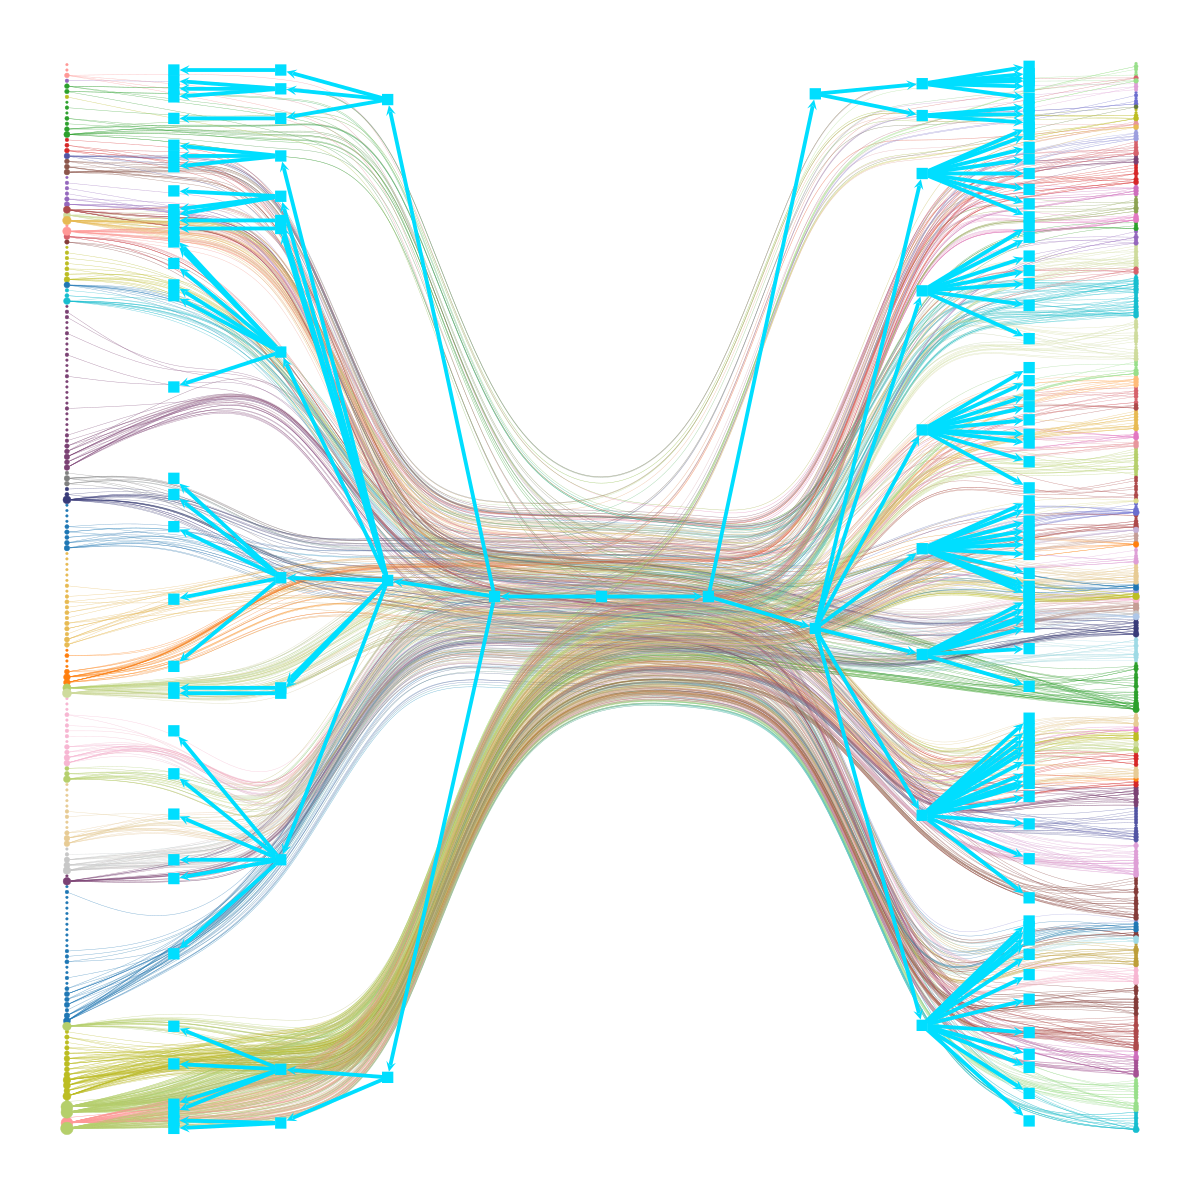

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fed501abe00, at 0x7fecd258d6d0>,
 <GraphView object, directed, with 713 vertices and 712 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fecd258d8e0, at 0x7fecc30e7bc0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fecd258d8e0, at 0x7fecc30e5460>, False), at 0x7fecd258d8e0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fecd258d8e0, at 0x7fed50134b90>)

In [115]:
## Create the sbmtm model
model = sbmtm()

## we have to create the customer-MCC network from the data
model.make_graph(MCC,documents=CustomerID,counts=True)
SEED = 41
gt.seed_rng(SEED) ## seed for graph-tool's random number generator --> same results

#fit the model
model.fit()

print('The lowest entropy was {}, and the state has {} blocks at level 0'.format(model.state.entropy(),model.state.get_levels()[0].get_nonempty_B()))
with open('./Results/minimized_model_seed_{}.pkl'.format(SEED),'wb') as f:
    pickle.dump(model,f)
    
#Plot
model.state.draw(subsample_edges=1000,layout='bipartite',bip_aspect=1,
           hvertex_size=8, hedge_pen_width=1.9, hedge_color="#00deff", hvertex_fill_color="#00DEFF", output_size=(600, 600))

In [113]:
# get the cluster at different levels
levels = model.state.get_levels()
for i in range(3):
    print('Level',i)
    print('The lowest entropy was {}, and the state has {} blocks at level {}'.format(levels[i].entropy(),levels[i].get_nonempty_B(),i))
    print('The number of edges between blocks is {}'.format(levels[i].get_matrix().nnz))
    print('The number of edges within blocks is {}'.format(levels[i].get_matrix().sum()))

Level 0
The lowest entropy was 30478.885709302176, and the state has 114 blocks at level 0
The number of edges between blocks is 3180
The number of edges within blocks is 40648.0
Level 1
The lowest entropy was 16674.59352159356, and the state has 23 blocks at level 1
The number of edges between blocks is 238
The number of edges within blocks is 40648.0
Level 2
The lowest entropy was 6841.784213238255, and the state has 5 blocks at level 2
The number of edges between blocks is 12
The number of edges within blocks is 40648.0


In [121]:
# get the number of cluster in document space at level 1
len(model.topics(l=1))

14

In [123]:
model.topics(l=1, n=10)

{0: [('Miscellaneous & Specialty Retail Stores', 0.19889196675900278),
  ('Parking Lots and Garages', 0.12520775623268698),
  ('News Dealers & Newsstands', 0.0742382271468144),
  ("Men's and Women's Clothing Stores", 0.058725761772853186),
  ('Recreation Services - Not Elsewhere Classified', 0.056509695290858725),
  ('Gift, Card, Novelty, and Souvenir Stores', 0.054293628808864264),
  ('Lodging - Hotels, Motels, and Resorts', 0.050415512465373964),
  ('Package Stores--Beer, Wine, and Liquor', 0.04709141274238227),
  ('Beauty and Barber Shops', 0.043213296398891966),
  ('Postal Services', 0.038781163434903045)],
 1: [('Passenger Rail (train)', 0.41731066460587324),
  ('Bus Lines, includes Charters/Tour Buses', 0.37094281298299847),
  ('Transportation Services-not elsewhere classified', 0.07727975270479134),
  ('Cigar Stores & Stands', 0.06491499227202473),
  ('Trailer Parks and Campgrounds', 0.027820710973724884),
  ('Miscellaneous Personal Services - Not Elsewhere Classified',
   0.027

In [142]:
model.get_groups(l=1)

{'Bd': 9,
 'Bw': 14,
 'p_tw_w': array([[1., 0., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'p_td_d': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'p_w_tw': array([[1.66204986e-03, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 7.72797527e-03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000

In [153]:
model.clusters(l=1)

{0: [('434a60bb-b98e-47e6-87e1-aa1bd913bde1', 1.0),
  ('fccc649d-a523-4f39-bc66-1e46a8ced7e5', 1.0),
  ('b88e862d-644e-40f3-af94-049cdb76c52e', 1.0),
  ('a3ba222c-b1a7-4686-bb63-539d43797376', 1.0),
  ('15182db2-b11c-4143-9dc5-f6ae29713936', 1.0),
  ('bfa3923b-5a03-4e9f-8301-7a65e681b068', 1.0),
  ('0ae40402-f81b-4ce1-801f-94246b674aef', 1.0),
  ('5b808c6c-9bc2-4298-8d4f-c1f4d3e46a95', 1.0),
  ('481427cb-72cb-4c84-8f19-03eee1f709b2', 1.0),
  ('a63ba1d5-c8ee-408b-ade5-b717cce075af', 1.0)],
 1: [('f601e896-6666-4ff6-a6d0-4748d1412f24', 1.0),
  ('2256d0d9-c1a8-4e6f-baa3-9b7c7204df95', 1.0),
  ('fc596873-9db8-49c5-83be-66a570548f06', 1.0),
  ('f5cb8a1b-f495-4bf5-b261-d3704e2d9324', 1.0),
  ('75152c18-f4aa-42e2-ad90-ad74beddd74c', 1.0),
  ('517489bc-51c2-40ff-af4f-8ed305d39500', 1.0),
  ('961ad67a-93b7-4f16-a454-3e70cf55a229', 1.0),
  ('4b250d93-3e2d-4388-bd71-66c5e4b0acf1', 1.0),
  ('1c2b7d51-a0c4-4074-8359-16149dcae570', 1.0),
  ('eb6043b4-9a96-4552-95ac-8fc53a176e90', 1.0)],
 2: [('76720

In [197]:
# get the number of documents in each topic(cluster) at level 1
# model.clusters(l=1)
# print the number of documents in each topic(cluster) at level 1
x = 0
for i in range(len(model.clusters(l=1))):
    x += len(model.clusters(l=1,n=100)[i])
    print('The number of documents in topic {} is {}'.format(i+1,len(model.clusters(l=1,n=100)[i])))
print('The total number of documents is {}'.format(x))

The number of documents in topic 1 is 48
The number of documents in topic 2 is 39
The number of documents in topic 3 is 73
The number of documents in topic 4 is 34
The number of documents in topic 5 is 72
The number of documents in topic 6 is 48
The number of documents in topic 7 is 33
The number of documents in topic 8 is 15
The number of documents in topic 9 is 7
The total number of documents is 369


In [203]:
# plot the number of documents in each topic(cluster) at level 1, labeled by the topic(cluster) number
plt.figure(figsize=(10,6))
sns.barplot([len(model.clusters(l=1,n=100)[i]) for i in range(len(model.clusters(l=1)))])

TypeError: unhashable type: 'list'

<Figure size 1000x600 with 0 Axes>

### Model Analysis

In [167]:
Customer_clusters = model.clusters(l=1,n=100).items()
Customer_clusters = [[id for id, p in cluster] for i, cluster in Customer_clusters]
Customer_clusters

[['434a60bb-b98e-47e6-87e1-aa1bd913bde1',
  'fccc649d-a523-4f39-bc66-1e46a8ced7e5',
  'b88e862d-644e-40f3-af94-049cdb76c52e',
  'a3ba222c-b1a7-4686-bb63-539d43797376',
  '15182db2-b11c-4143-9dc5-f6ae29713936',
  'bfa3923b-5a03-4e9f-8301-7a65e681b068',
  '0ae40402-f81b-4ce1-801f-94246b674aef',
  '5b808c6c-9bc2-4298-8d4f-c1f4d3e46a95',
  '481427cb-72cb-4c84-8f19-03eee1f709b2',
  'a63ba1d5-c8ee-408b-ade5-b717cce075af',
  '7a2f20ea-5b1f-4582-a831-b6f44f06d148',
  'c3924705-b945-49a4-8cfd-00ac0e28b4ff',
  'bc417046-068f-49d2-bd29-ae34decc12fd',
  'd2f7ab36-24c1-4b3b-9002-8a6c46ae7fe8',
  'e065da2d-f8d5-4ebf-b3ae-c5b1f7010ac8',
  '21e6503a-8e75-400d-82bf-88c9ded1942b',
  '5e9b9ea8-e2ac-4b6e-a1a2-81a57d58e9b0',
  '55203a37-2196-40d6-90f6-19b3be2e1eae',
  'a3f05a19-8106-4056-ae5a-ac9eff24dba3',
  '59ff2fc0-cb02-4e93-8577-e1846fca86bb',
  'b2e1ff34-0ce4-4073-adc0-f145fe21bad8',
  '33049bbb-8ec1-4f79-9988-05a39cf1f93f',
  '3b4654ee-71e4-415a-9eac-a15b6c7129b6',
  '76a922c7-0cf5-4a75-9e30-69c34ba

#### Calculate the CO2 emissions per GBP for clusters

In [ ]:
def calculate_CO2_to_amount_ratio(customer_cluster, df):
    # Filter the DataFrame to include only customers in the current cluster
    cluster_data = df[df['customerId'].isin(customer_cluster)]
    
    # Sum up the total CO2 emissions and total amount spent for the cluster
    total_CO2 = cluster_data['Total_CO2_Emissions'].sum()
    total_amount_spent = cluster_data['Total_Amount_Spent'].sum()
    
    # Calculate the ratio of CO2 emissions to the amount spent
    if total_amount_spent != 0:
        ratio = total_CO2 / total_amount_spent
    else:
        ratio = 0.0
    
    return ratio

Length = []
ClusterCO2_ratio = []

for i, cluster in enumerate(Customer_clusters):
    # Calculate the CO2 to amount spent ratio for the current cluster
    ratio = calculate_CO2_to_amount_ratio(cluster, df)
    
    # Append cluster length and CO2 to amount spent ratio to lists
    Length.append(len(cluster))
    ClusterCO2_ratio.append(ratio)
    
    # Print the results
    print(f"The customer cluster {i+1} has {Length[i]} customers and the CO2 emissions to amount spent ratio for it is {ClusterCO2_ratio[i]}")

# Calculate average age for each cluster
ClusterAvgAge = [calculate_average_age_and_IMD(i, customer_data_cleaned, Customer_clusters)[0] for i in range(len(Customer_clusters))]

# Scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figsize as needed
plt.scatter(ClusterAvgAge, ClusterCO2_ratio, color='blue', marker='o')

# Annotate each point with the cluster number
for i, (age, ratio) in enumerate(zip(ClusterAvgAge, ClusterCO2_ratio)):
    plt.text(age, ratio, f'Cluster {i+1}', fontsize=9, ha='center', va='top')

plt.title('Scatter Plot of Average Age vs. CO2 Emissions to Amount Spent Ratio')
plt.xlabel('Average Age of Customers in Cluster')
plt.ylabel('CO2 Emissions to Amount Spent Ratio')
plt.grid(True)
plt.show()

# Calculate average IMD_Rank for each cluster
ClusterAvgIMD = [calculate_average_age_and_IMD(i, customer_data_cleaned, Customer_clusters)[1] for i in range(len(Customer_clusters))]

# Scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figsize as needed
plt.scatter(ClusterAvgIMD, ClusterCO2_ratio, color='blue', marker='o')

# Annotate each point with the cluster number
for i, (imd, ratio) in enumerate(zip(ClusterAvgIMD, ClusterCO2_ratio)):
    plt.text(imd, ratio, f'Cluster {i+1}', fontsize=9, ha='center', va='top')

plt.title('Scatter Plot of Average IMD Rank vs. CO2 Emissions to Amount Spent Ratio')
plt.xlabel('Average IMD Rank of Customers in Cluster')
plt.ylabel('CO2 Emissions to Amount Spent Ratio')
plt.grid(True)
plt.show()

#### IMD and Age by clusters

In [187]:
df_imd = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='IMD_Rank')
df_customer = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='ekko_customer_info')
print('Before dropping NaN values:')
print(df_imd.shape)
print(df_customer.shape)
df_imd.dropna(inplace=True)
df_imd.reset_index(drop=True, inplace=True)
df_customer.dropna(inplace=True)
df_customer.reset_index(drop=True, inplace=True)
print('After dropping NaN values:')
print(df_imd.shape)
print(df_customer.shape)
df_customer.head()

Before dropping NaN values:
(874, 28)
(12986, 6)
After dropping NaN values:
(874, 28)
(11931, 6)


,Sender_customer_Id,address.postcode,address.townOrCity,createdAt,dateOfBirth,nationality
0,eecbba00-41c0-4111-ae83-286a302fed0c,NW1 9DR,London,2021-11-04T12:46:07.257Z,1995-05-21T00:00:00.000Z,United Kingdom
1,dff827bc-d6bb-4fd0-ae3d-d82786f9e5ad,SM2 6DU,Sutton,2021-12-09T18:04:46.294Z,1981-10-30T00:00:00.000Z,United Kingdom
2,bb10d50e-5e6a-43c2-bd6d-323b7d9c731f,SW1W0NY,London,2021-12-15T11:41:54.937Z,1991-04-11T00:00:00.000Z,United Kingdom
3,5c0a9926-a3b5-4441-945b-c1f619ed339a,SM25HT,Sutton,2021-12-15T13:33:27.821Z,1986-05-22T00:00:00.000Z,United Kingdom
4,12ea2e69-cea2-4e47-9d21-55402dd47811,SW1W0NY,London,2021-12-15T14:31:52.354Z,1991-04-11T00:00:00.000Z,United Kingdom


In [188]:
from datetime import datetime
from dateutil import parser
# calculate the age of the customers
df_customer['age'] = df_customer.apply(lambda x: 2024 - parser.parse(x['dateOfBirth']).year, axis=1)
df_customer.head()

,Sender_customer_Id,address.postcode,address.townOrCity,createdAt,dateOfBirth,nationality,age
0,eecbba00-41c0-4111-ae83-286a302fed0c,NW1 9DR,London,2021-11-04T12:46:07.257Z,1995-05-21T00:00:00.000Z,United Kingdom,29
1,dff827bc-d6bb-4fd0-ae3d-d82786f9e5ad,SM2 6DU,Sutton,2021-12-09T18:04:46.294Z,1981-10-30T00:00:00.000Z,United Kingdom,43
2,bb10d50e-5e6a-43c2-bd6d-323b7d9c731f,SW1W0NY,London,2021-12-15T11:41:54.937Z,1991-04-11T00:00:00.000Z,United Kingdom,33
3,5c0a9926-a3b5-4441-945b-c1f619ed339a,SM25HT,Sutton,2021-12-15T13:33:27.821Z,1986-05-22T00:00:00.000Z,United Kingdom,38
4,12ea2e69-cea2-4e47-9d21-55402dd47811,SW1W0NY,London,2021-12-15T14:31:52.354Z,1991-04-11T00:00:00.000Z,United Kingdom,33


In [191]:
df_imd['age'] = df_imd['CustomerId'].map(df_customer.set_index('Sender_customer_Id')['age'])
df_imd.head()

,CustomerId,Index_of_Multiple_Deprivation_Decile,Postcode_Status,LSOA_code,LSOA_Name,Index_of_Multiple_Deprivation_Rank,Income_Rank,Income_Decile,Income_Score,Employment_Rank,...,Barriers_to_Housing_and_Services_Decile,Living_Environment_Rank,Living_Environment_Decile,IDACI_Rank,IDACI_Decile,IDACI_Score,IDAOPI_Rank,IDAOPI_Decile,IDAOPI_Score,age
0,db9b8ecb-173d-43fb-bff6-b7f7b54b603b,3,Live,E01010959,Calderdale 020D E01010959,8106,7040,3,0.194,5093,...,10,9666,3,6327,2,0.260,12134,4,0.172,29.0
1,60614561-6838-4200-a37c-978cdffad096,2,Live,E01011043,Kirklees 031B E01011043,5947,6529,2,0.202,6750,...,5,1975,1,9700,3,0.206,3799,2,0.324,26.0
2,886926ad-2f76-4746-a7fc-ca1473c848a3,9,Live,E01004694,Westminster 016C E01004694,26491,31488,10,0.026,32231,...,3,5526,2,32013,10,0.019,19729,7,0.102,27.0
3,55929e08-6995-4766-ad89-402bb47358f8,4,Live,E01027498,Tynedale 005B E01027498,12152,8097,3,0.179,9178,...,8,32328,10,9016,3,0.216,7387,3,0.241,28.0
4,ae54b0a2-7ad3-432c-ae1b-040e9365f8ee,7,Live,E01001642,Greenwich 038C E01001642,22742,26579,9,0.048,30198,...,6,6012,2,21946,7,0.082,25719,8,0.067,56.0


In [193]:
def calculate_average_age_and_IMD(cluster_index, df_imd, clusters):
    # Get the customer IDs in the specified cluster
    customer_cluster = clusters[cluster_index]

    # Filter the DataFrame to include only customers in the current cluster
    cluster_data = df_imd[df_imd['CustomerId'].isin(customer_cluster)]
    
    # Calculate the average age and IMD_Rank for the cluster
    average_age = cluster_data['age'].mean()
    average_IMD = cluster_data['Index_of_Multiple_Deprivation_Decile'].mean()
    
    return average_age, average_IMD
customer_data_cleaned = df_imd
# Example usage:
for index in range(0,9):
    cluster_index = index  # Replace this with the desired cluster index
    avg_age, avg_IMD = calculate_average_age_and_IMD(cluster_index, customer_data_cleaned, Customer_clusters)
    print(f"For cluster {cluster_index + 1}, the average age is {avg_age:.2f} and the average IMD_Rank is {avg_IMD:.2f}")


For cluster 1, the average age is 29.29 and the average IMD_Rank is 4.70
For cluster 2, the average age is 26.88 and the average IMD_Rank is 3.38
For cluster 3, the average age is 32.34 and the average IMD_Rank is 4.88
For cluster 4, the average age is 41.30 and the average IMD_Rank is 6.89
For cluster 5, the average age is 31.84 and the average IMD_Rank is 4.21
For cluster 6, the average age is 28.07 and the average IMD_Rank is 3.33
For cluster 7, the average age is 29.89 and the average IMD_Rank is 3.32
For cluster 8, the average age is 29.11 and the average IMD_Rank is 6.11
For cluster 9, the average age is 42.80 and the average IMD_Rank is 4.80


#### Heatmaps of Purchases by Cluster

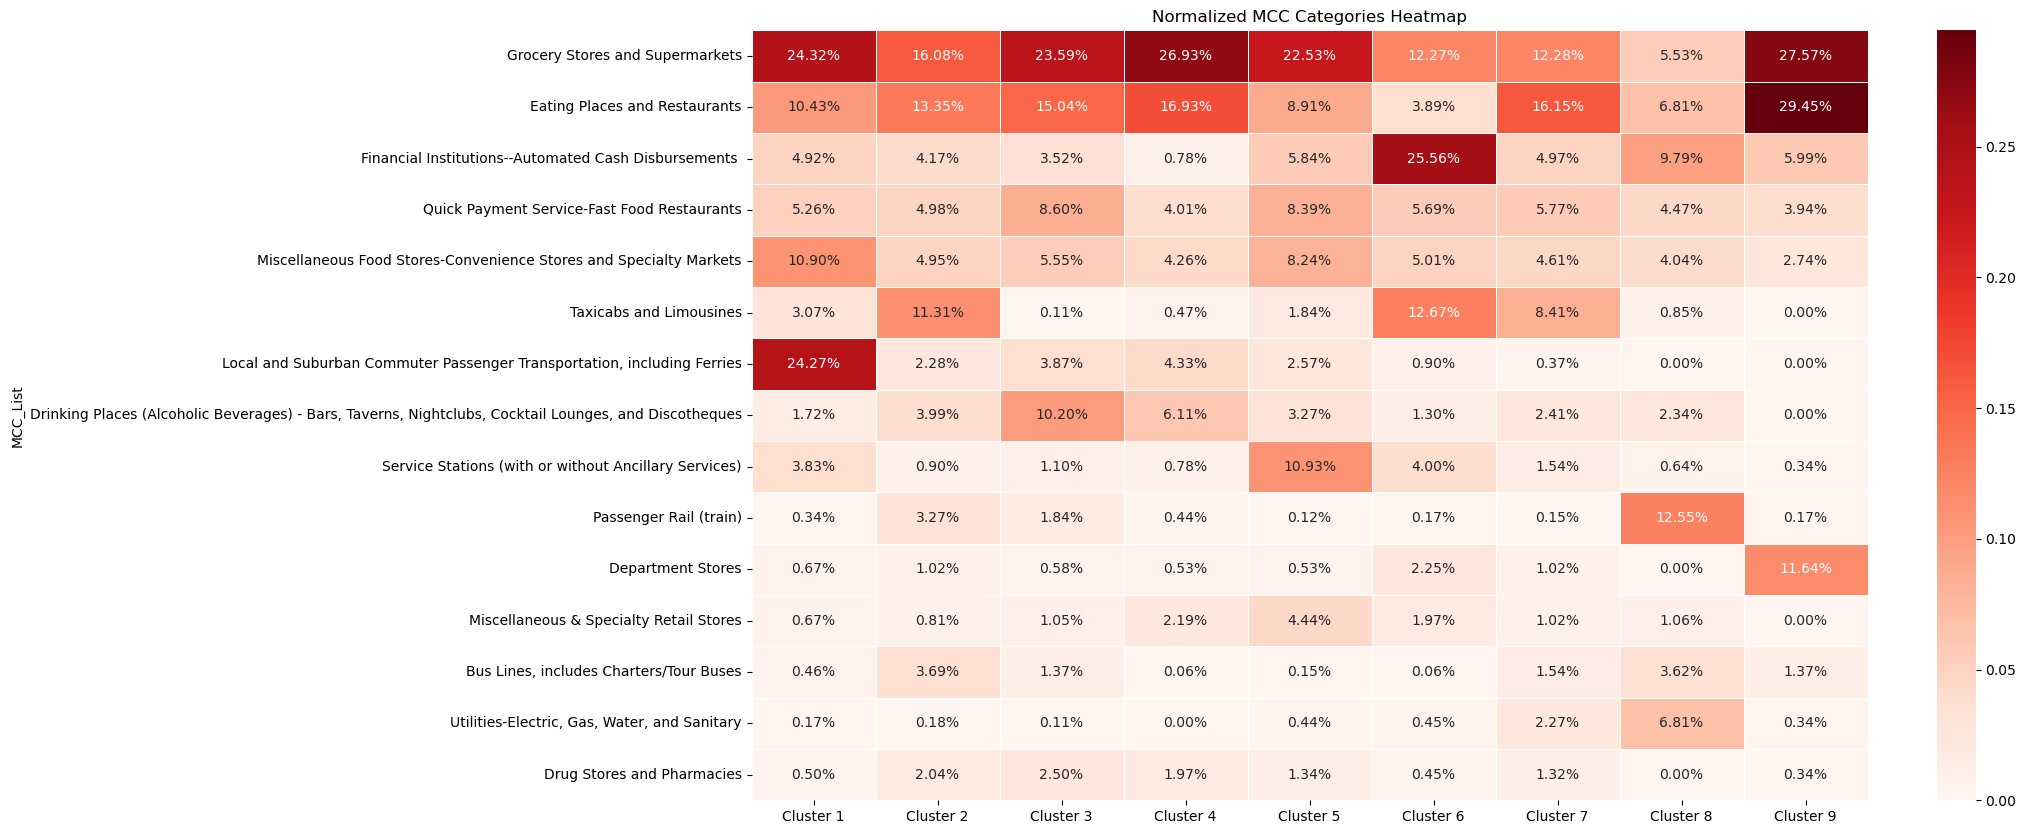

In [194]:
df = filtered_data
def mcc_heatmap_normalized(clusters, df):
    cluster_counts = []

    # Get the normalized MCC transaction counts for each cluster
    for i, cluster in enumerate(clusters):
        # Filter the DataFrame based on the customer IDs in the cluster
        filtered_df = df[df['customerId'].isin(cluster)]
        mcc_counts_normalized = filtered_df['MCC_List'].value_counts(normalize=True).rename(f'Cluster {i + 1}')
        cluster_counts.append(mcc_counts_normalized)

    # Combine the normalized counts into a single DataFrame
    mcc_df_normalized = pd.concat(cluster_counts, axis=1, sort=True).fillna(0)

    # Get the top 10 categories with the highest average transaction percentages
    top_categories_normalized = mcc_df_normalized.sum(axis=1).nlargest(15).index

    # Filter the DataFrame to keep only the top categories
    mcc_top_df_normalized = mcc_df_normalized.loc[top_categories_normalized]

    # Create a heatmap
    plt.figure(figsize=(18, 10))
    sns.heatmap(mcc_top_df_normalized, cmap='Reds', annot=True, fmt='.2%', linewidths=.5)
    plt.title('Normalized MCC Categories Heatmap')
    plt.show()

mcc_heatmap_normalized(Customer_clusters[0:38], df)


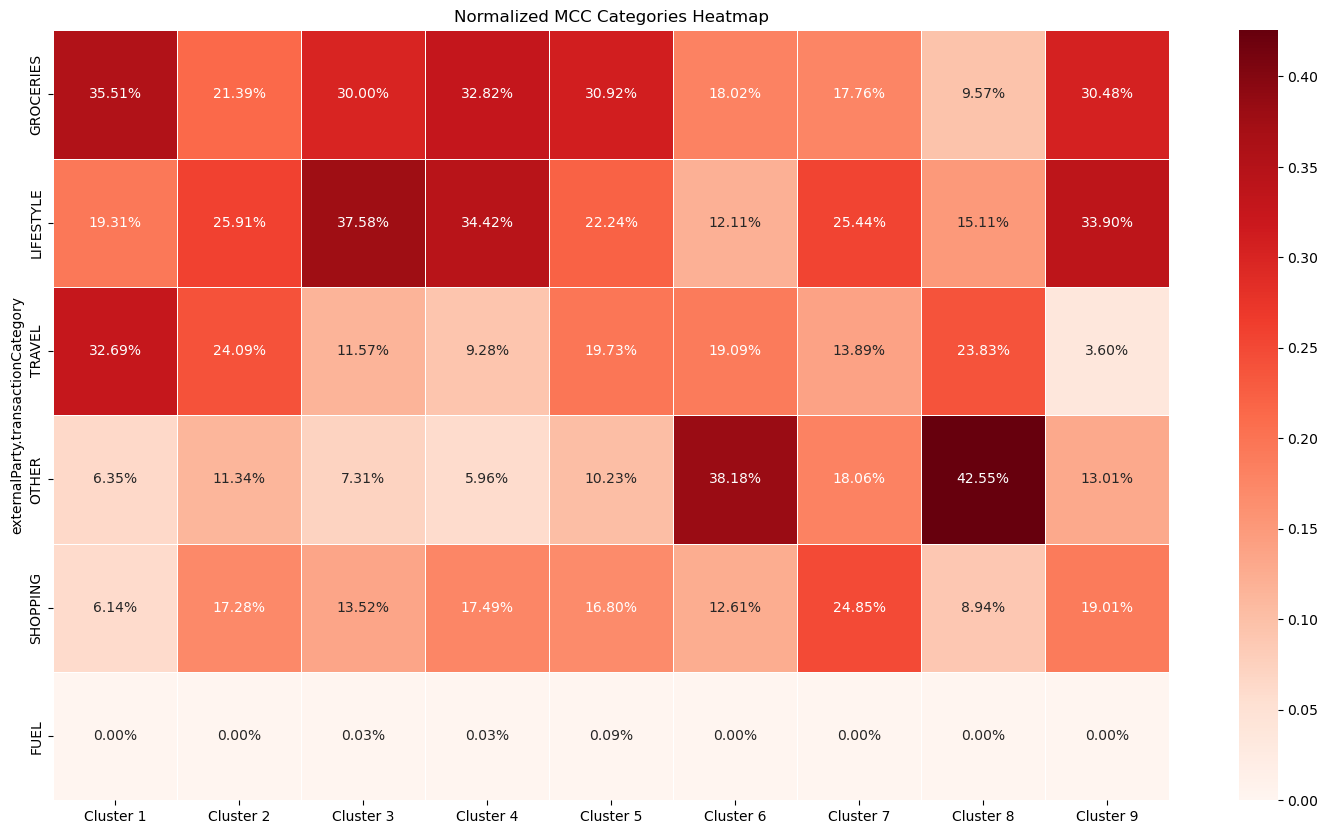

In [195]:
df = filtered_data
def cate_heatmap_normalized(clusters, df):
    cluster_counts = []

    # Get the normalized MCC transaction counts for each cluster
    for i, cluster in enumerate(clusters):
        # Filter the DataFrame based on the customer IDs in the cluster
        filtered_df = df[df['customerId'].isin(cluster)]
        cate_counts_normalized = filtered_df['externalParty.transactionCategory'].value_counts(normalize=True).rename(f'Cluster {i + 1}')
        cluster_counts.append(cate_counts_normalized)

    # Combine the normalized counts into a single DataFrame
    cate_df_normalized = pd.concat(cluster_counts, axis=1, sort=True).fillna(0)

    # Get the top 10 categories with the highest average transaction percentages
    top_categories_normalized = cate_df_normalized.sum(axis=1).nlargest(6).index

    # Filter the DataFrame to keep only the top categories
    cate_top_df_normalized = cate_df_normalized.loc[top_categories_normalized]

    # Create a heatmap
    plt.figure(figsize=(18, 10))
    sns.heatmap(cate_top_df_normalized, cmap='Reds', annot=True, fmt='.2%', linewidths=.5)
    plt.title('Normalized MCC Categories Heatmap')
    plt.show()

cate_heatmap_normalized(Customer_clusters[0:38], df)

relative importance

two-level heatmap


In [217]:
# calculate the average co2 emission per pound and total number of transaction for each customer
result = filtered_data.groupby('customerId').agg(total_co2 = ('transactionFootPrint.carbonEmissionInGrams', 'sum'),total_amount=('amount.value', 'sum'), transaction_count=('customerId', 'size'))
result['average_co2_per_pound'] = result['total_co2'] / result['total_amount']
# normalize the data
result['total_co2'] = (result['total_co2'] - result['total_co2'].mean()) / result['total_co2'].std()
result['total_amount'] = (result['total_amount'] - result['total_amount'].mean()) / result['total_amount'].std()
result['average_co2_per_pound'] = (result['average_co2_per_pound'] - result['average_co2_per_pound'].mean()) / result['average_co2_per_pound'].std()
result['transaction_count'] = (result['transaction_count'] - result['transaction_count'].mean()) / result['transaction_count'].std()
result.head()

,total_co2,total_amount,transaction_count,average_co2_per_pound
customerId,,,,
01968de9-41cb-4509-b0a6-6bdc02700150,1.885294,2.513451,3.421743,-0.128694
01b34ce5-ce43-4c2d-a73d-5294376bd399,-0.083921,-0.122645,-0.490151,0.026886
01b4698f-32be-4bc0-9b69-b3024ac18004,-0.308146,-0.239822,-0.149342,-0.240190
01ef943c-d661-48b0-9c0b-bb456a7d998d,0.031179,-0.190149,-0.223431,0.398112
03025a2b-9179-4da9-8dff-af4a3179ce7f,-0.074867,0.278659,0.917538,-0.361719


In [213]:
# create a color map with 9 colors
colors = sns.color_palette('hsv', 9)
# create a color dictionary for the clusters, based on the customer_clusters
cluster_color_dict = {}
for i, cluster in enumerate(Customer_clusters):
    for customer in cluster:
        cluster_color_dict[customer] = colors[i]
cluster_color_dict

{'434a60bb-b98e-47e6-87e1-aa1bd913bde1': (1.0, 0.5790446966917554, 0.0),
 'fccc649d-a523-4f39-bc66-1e46a8ced7e5': (1.0, 0.5790446966917554, 0.0),
 'b88e862d-644e-40f3-af94-049cdb76c52e': (1.0, 0.5790446966917554, 0.0),
 'a3ba222c-b1a7-4686-bb63-539d43797376': (1.0, 0.5790446966917554, 0.0),
 '15182db2-b11c-4143-9dc5-f6ae29713936': (1.0, 0.5790446966917554, 0.0),
 'bfa3923b-5a03-4e9f-8301-7a65e681b068': (1.0, 0.5790446966917554, 0.0),
 '0ae40402-f81b-4ce1-801f-94246b674aef': (1.0, 0.5790446966917554, 0.0),
 '5b808c6c-9bc2-4298-8d4f-c1f4d3e46a95': (1.0, 0.5790446966917554, 0.0),
 '481427cb-72cb-4c84-8f19-03eee1f709b2': (1.0, 0.5790446966917554, 0.0),
 'a63ba1d5-c8ee-408b-ade5-b717cce075af': (1.0, 0.5790446966917554, 0.0),
 '7a2f20ea-5b1f-4582-a831-b6f44f06d148': (1.0, 0.5790446966917554, 0.0),
 'c3924705-b945-49a4-8cfd-00ac0e28b4ff': (1.0, 0.5790446966917554, 0.0),
 'bc417046-068f-49d2-bd29-ae34decc12fd': (1.0, 0.5790446966917554, 0.0),
 'd2f7ab36-24c1-4b3b-9002-8a6c46ae7fe8': (1.0, 0.57

In [218]:
# map the color dictionary to the customer_id in the result dataframe
result['color'] = result.index.map(cluster_color_dict)
result.head()

,total_co2,total_amount,transaction_count,average_co2_per_pound,color
customerId,,,,,
01968de9-41cb-4509-b0a6-6bdc02700150,1.885294,2.513451,3.421743,-0.128694,"(0.23970412205706326, 1.0, 0.0)"
01b34ce5-ce43-4c2d-a73d-5294376bd399,-0.083921,-0.122645,-0.490151,0.026886,"(0.14595412205706287, 0.0, 1.0)"
01b4698f-32be-4bc0-9b69-b3024ac18004,-0.308146,-0.239822,-0.149342,-0.240190,"(0.14595412205706287, 0.0, 1.0)"
01ef943c-d661-48b0-9c0b-bb456a7d998d,0.031179,-0.190149,-0.223431,0.398112,"(0.0, 1.0, 0.9647031631761764)"
03025a2b-9179-4da9-8dff-af4a3179ce7f,-0.074867,0.278659,0.917538,-0.361719,"(0.0, 1.0, 0.3625004724974957)"


In [220]:
colors

[(1.0, 0.5790446966917554, 0.0),
 (0.8187488187488188, 1.0, 0.0),
 (0.23970412205706326, 1.0, 0.0),
 (0.0, 1.0, 0.3625004724974957),
 (0.0, 1.0, 0.9647031631761764),
 (0.0, 0.4562523625023627, 1.0),
 (0.14595412205706287, 0.0, 1.0),
 (0.724998818748819, 0.0, 1.0),
 (1.0, 0.0, 0.6727946966917553)]

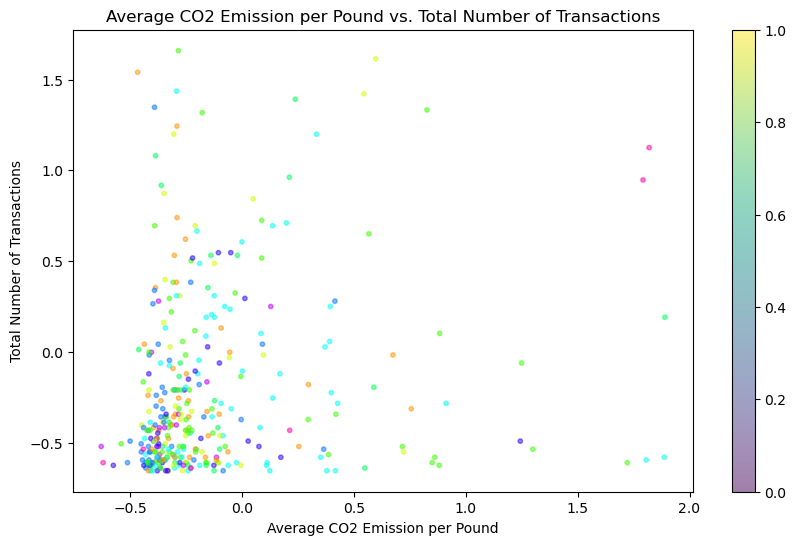

In [225]:
# plot each customer on a scatter plot with x-axis as the average co2 emission per pound and y-axis as the total number of transaction, color by the cluster
plt.figure(figsize=(10, 6))
# create a scatter plot
df_plot = result[(result['transaction_count'] < 2)&(result['average_co2_per_pound'] < 2)]
plt.scatter(df_plot['average_co2_per_pound'], df_plot['transaction_count'], c=df_plot['color'], alpha=0.5, s=10)
plt.xlabel('Average CO2 Emission per Pound')
plt.ylabel('Total Number of Transactions')
plt.title('Average CO2 Emission per Pound vs. Total Number of Transactions')
plt.colorbar()
plt.show()